# Bitcoin Price Movement Prediction Project
This notebook demonstrates a machine learning project focused on predicting the next-day price movement of Bitcoin based on historical price data and technical indicators.
The process includes data preprocessing, feature engineering, visualization of trends and volatility, and training multiple classification models to evaluate their predictive performance.

The goal is to determine whether the closing price of Bitcoin will increase or decrease the following day using time series data and statistical features.

### This project/file/script was developed by Abolfazl Karimi.

##  Import libraries

In [1]:
# Import necessary libraries for data analysis, visualization, and modeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

##  Load and check data

In [3]:
# Read Bitcoin historical data from CSV file
df = pd.read_csv("bitcoin.csv")
df.head()  # Show first few rows

,Date,Open,High,Low,Close,Vol.
0,2013-01-01,13.5,13.6,13.2,13.3,28.41K
1,2013-01-02,13.3,13.4,13.2,13.3,17.97K
2,2013-01-03,13.3,13.5,13.3,13.4,18.03K
3,2013-01-04,13.4,13.5,13.3,13.5,29.64K
4,2013-01-05,13.5,13.6,13.3,13.4,21.33K


In [4]:
# Check dataset info and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3793 entries, 0 to 3792
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3793 non-null   object 
 1   Open    3793 non-null   float64
 2   High    3793 non-null   float64
 3   Low     3793 non-null   float64
 4   Close   3793 non-null   float64
 5   Vol.    3793 non-null   object 
dtypes: float64(4), object(2)
memory usage: 177.9+ KB


## Data cleaning & preprocessing

In [5]:
# Convert 'Vol.' column (with K suffix) to numeric
def convert_kmb_to_number(x):
    if isinstance(x, str):
        return float(x[:-1]) * 1e3
    return x
df['Vol.'] = df['Vol.'].apply(convert_kmb_to_number)

# Convert 'Date' column to datetime and sort by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
print(f"From: {df['Date'].min()} To: {df['Date'].max()}")


From: 2013-01-01 00:00:00 To: 2023-05-21 00:00:00


## Plot closing price over time

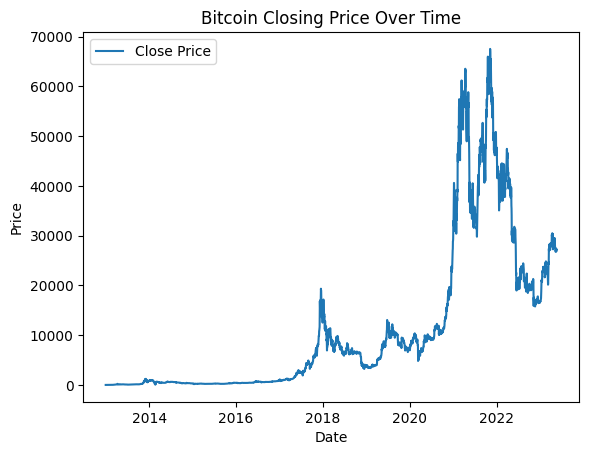

In [6]:
# Plot Bitcoin closing price over time
plt.close()
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Closing Price Over Time')
plt.legend()
plt.show();


## Correlation matrix

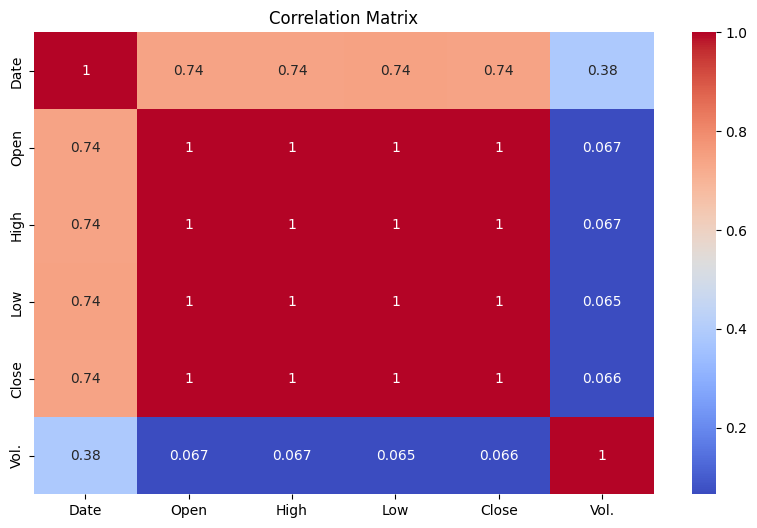

In [7]:
# Plot heatmap to visualize correlations between numeric features
plt.close()
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show();


## Create new features

In [8]:
# Add moving averages and rolling standard deviation
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA30'] = df['Close'].rolling(window=30).mean()
df['MA90'] = df['Close'].rolling(window=90).mean()
df['rolling_std_7'] = df['Close'].rolling(window=7).std()

# Add date-based and price-based features
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df['close-open']  = df['Close'] - df['Open']
df['high-low']  = df['High'] - df['Low']

# Define target: 1 if tomorrow's close price > today's close price
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

# Drop rows with NaN after moving average calculation
df = df.dropna(subset=['MA90'])
df.head()


,Date,Open,High,Low,Close,Vol.,MA7,MA30,MA90,rolling_std_7,year,month,day,is_quarter_end,close-open,high-low,target
89,2013-03-31,92.2,93.8,91.0,93.0,21130.0,86.128571,58.270000,33.282222,7.371502,2013,3,31,1,0.8,2.8,1
90,2013-04-01,93.0,106.0,92.2,104.0,90560.0,90.471429,60.593333,34.290000,7.707510,2013,4,1,0,11.0,13.8,1
91,2013-04-02,104.0,118.4,99.0,118.0,81290.0,96.114286,63.376667,35.453333,11.165785,2013,4,2,0,14.0,19.4,1
92,2013-04-03,118.0,147.0,110.0,135.0,152710.0,102.700000,66.670000,36.804444,17.816191,2013,4,3,0,17.0,37.0,0
93,2013-04-04,135.0,142.1,116.4,132.1,88360.0,109.257143,69.730000,38.122222,19.129546,2013,4,4,0,-2.9,25.7,1


## Visualize moving averages and volatility

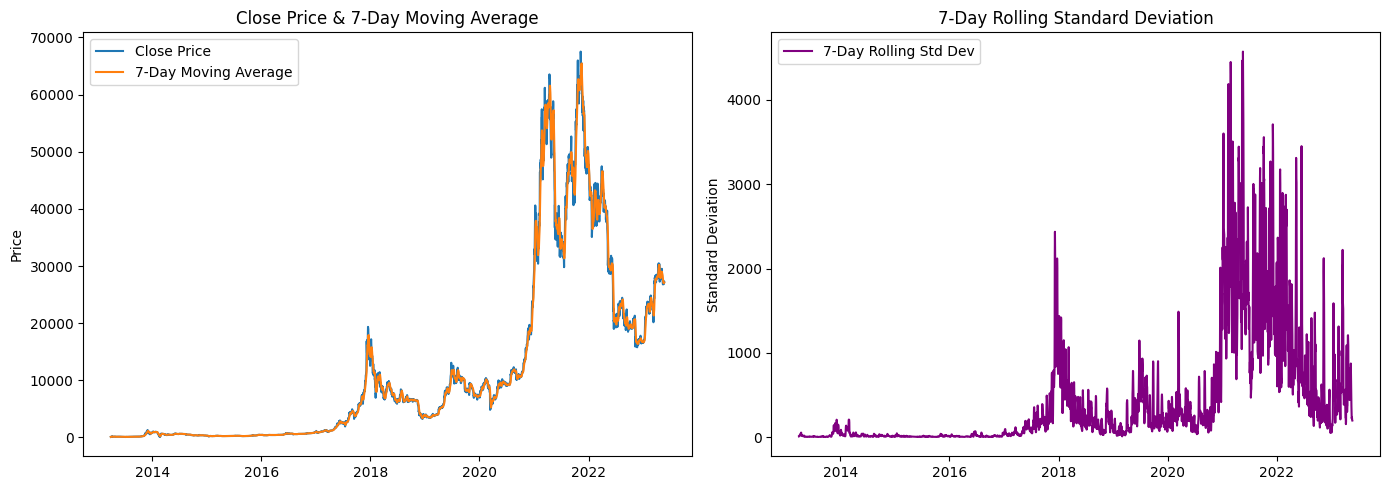

In [9]:
# Close price with 7-day moving average and rolling std dev
plt.close()
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
axs[0].plot(df['Date'], df['Close'], label='Close Price')
axs[0].plot(df['Date'], df['MA7'], label='7-Day Moving Average')
axs[0].set_title('Close Price & 7-Day Moving Average')
axs[0].set_ylabel('Price')
axs[0].legend()

axs[1].plot(df['Date'], df['rolling_std_7'], label='7-Day Rolling Std Dev', color='purple')
axs[1].set_title('7-Day Rolling Standard Deviation')
axs[1].set_ylabel('Standard Deviation')
axs[1].legend()

plt.tight_layout()
plt.show();


## Plot longer moving averages

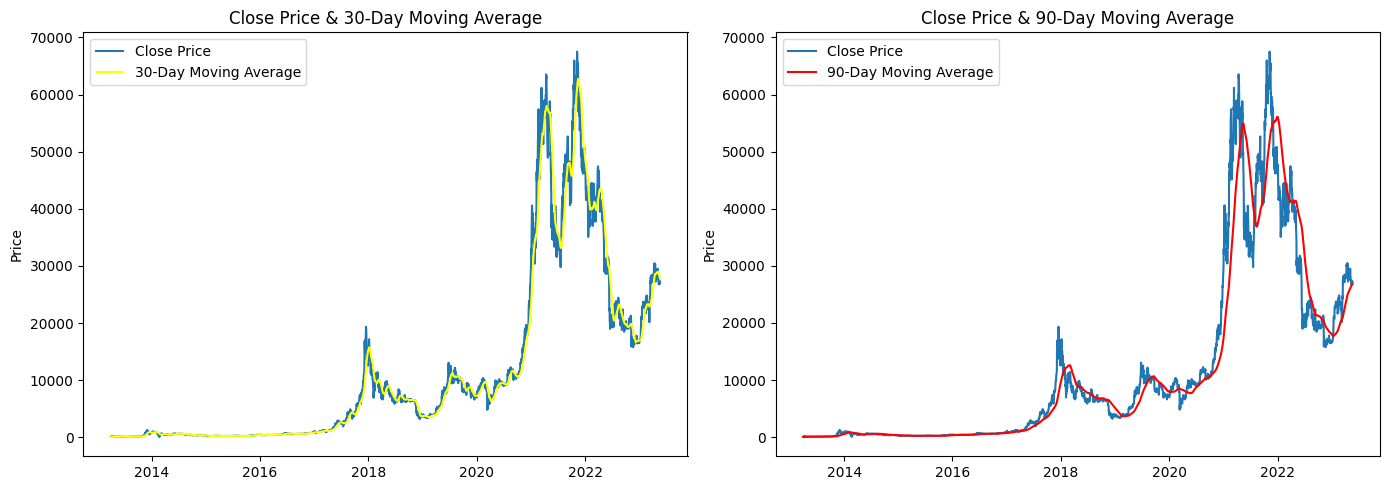

In [11]:
# Close price with 30-day and 90-day moving averages
plt.close()
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
axs[0].plot(df['Date'], df['Close'], label='Close Price')
axs[0].plot(df['Date'], df['MA30'], label='30-Day Moving Average', color='yellow')
axs[0].set_title('Close Price & 30-Day Moving Average')
axs[0].set_ylabel('Price')
axs[0].legend()

axs[1].plot(df['Date'], df['Close'], label='Close Price')
axs[1].plot(df['Date'], df['MA90'], label='90-Day Moving Average', color='red')
axs[1].set_title('Close Price & 90-Day Moving Average')
axs[1].set_ylabel('Price')
axs[1].legend()

plt.tight_layout()
plt.show();


## Check target class distribution

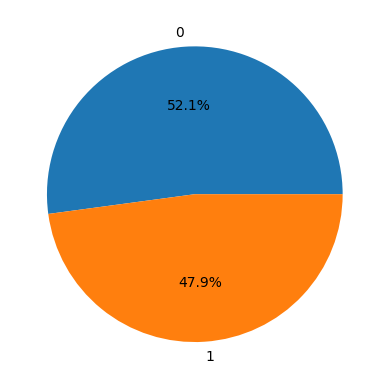

In [13]:
# Plot distribution of target variable (up/down next day)
plt.close()
plt.pie(df['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show();


## Feature scaling & split data

In [14]:
# Select features and scale them
features = df[['close-open', 'high-low', 'is_quarter_end', 'MA30', 'Vol.', 'MA90', 'MA7']]
target = df['target']
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split data into train and validation sets (no shuffle to keep time order)
X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.15, random_state=2022, shuffle=False)
print(X_train.shape, X_valid.shape)


(3148, 7) (556, 7)


## Build & evaluate models

In [20]:
# Define machine learning models
models = [
    LogisticRegression(
        max_iter=1000, 
        class_weight='balanced',
        random_state=42
        ),
    GradientBoostingClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
        ),
    SVC(
        probability=True,
        class_weight='balanced',
        kernel='rbf',
        random_state=42
    )  
]

# Train each model and calculate ROC AUC for train and validation sets
train_scores = []
valid_scores = []
model_names = []
for model in models:
    model.fit(X_train, Y_train)
    train_auc = roc_auc_score(Y_train, model.predict_proba(X_train)[:,1])
    valid_auc = roc_auc_score(Y_valid, model.predict_proba(X_valid)[:,1])
    train_scores.append(train_auc)
    valid_scores.append(valid_auc)
    model_names.append(model.__class__.__name__)


## Visualize model performance

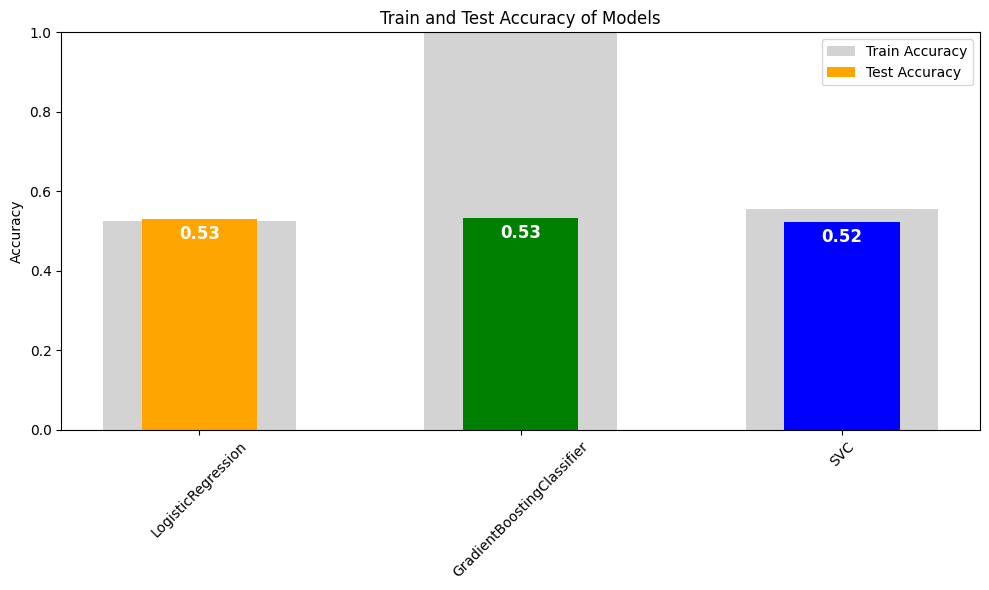

In [24]:
# Bar chart to compare ROC AUC on train and validation sets
x = np.arange(len(model_names))
width = 0.6
plt.close()
plt.figure(figsize=(10,6))
plt.bar(x, train_scores, width=width, color='lightgray', label='Train Accuracy')
plt.bar(x, valid_scores, width=width * 0.6, color=['orange', 'green', 'blue', 'purple', 'red'], label='Test Accuracy')

# Add score text on bars
for i in range(len(model_names)):
    plt.text(x[i], valid_scores[i] - 0.05, f"{valid_scores[i]:.2f}", ha='center', color='white', fontsize=12, fontweight='bold')

plt.xticks(x, model_names, rotation=45)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy of Models')
plt.legend()
plt.tight_layout()
plt.show();


## Conclusion
In this project, we used historical Bitcoin data to engineer relevant features and applied several machine learning models to predict next-day price movement.
Among the tested models, we compared their performance based on the ROC AUC score, which reflects how well each model distinguishes between upward and downward price trends.

Although no model was perfect — which is expected given the noisy and volatile nature of cryptocurrency markets — the results showed that incorporating moving averages and volatility indicators can provide useful signals for short-term predictions.

This project highlights the potential of combining technical analysis with machine learning techniques to gain insights into financial time series data.

## 🙏 Thanks
#### Thanks for reviewing this project.
This work was prepared and implemented by Abolfazl Karimi as part of a personal learning journey in machine learning and time series analysis.

